In [51]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

In [52]:
learning_rate = 0.001 
batch_size = 256
num_epochs = 10
num_classes = 10
normal_dig = 6

In [53]:
train_data = datasets.MNIST(root='mnist_data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='mnist_data', train=False, transform=transforms.ToTensor(), download=True)

# Filter only normal digits for training
indices = train_data.targets == normal_dig
train_data.targets, train_data.data = train_data.targets[indices], train_data.data[indices]

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [56]:
class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_size=8):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, bottleneck_size)  # 7x7x64 after Conv2d layers
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 7 * 7 * 64),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = AutoEncoder(bottleneck_size=8)
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_criterion = nn.MSELoss()

In [57]:
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    
    for batch_idx, (data, _) in enumerate(train_loader):
        reconstructed = model(data)
        loss = loss_criterion(reconstructed, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')

Epoch [1/10], Loss: 0.10815546646093328
Epoch [2/10], Loss: 0.05745457547406355
Epoch [3/10], Loss: 0.055420452263206244
Epoch [4/10], Loss: 0.05431816276783744
Epoch [5/10], Loss: 0.047572309616953135
Epoch [6/10], Loss: 0.035695715341717005
Epoch [7/10], Loss: 0.02799559710547328
Epoch [8/10], Loss: 0.02309307277513047
Epoch [9/10], Loss: 0.0202322614689668
Epoch [10/10], Loss: 0.01841233717277646


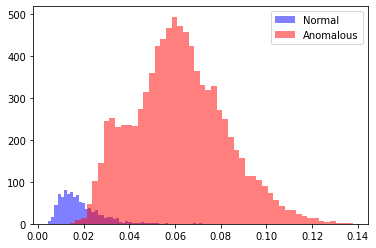

In [58]:
model.eval()
normal_loss = []
anomalous_loss = []

for batch_idx, (data, labels) in enumerate(test_loader):
    with torch.no_grad():
        reconstructed = model(data)
        
        for i in range(len(data)):
            loss = loss_criterion(reconstructed[i], data[i]).item()
            
            if labels[i].item() == normal_dig:
                normal_loss.append(loss)
            else:
                anomalous_loss.append(loss)

plt.hist(normal_loss, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(anomalous_loss, bins=50, alpha=0.5, color='red', label='Anomalous')
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Set the threshold for anomaly detection
threshold = 0.02

# True labels for the test data (1 if anomalous, 0 if normal)
true_labels = []

# Predictions based on the reconstruction error
predicted_labels = []

# Iterate through test data and calculate predictions based on threshold
for batch_idx, (data, labels) in enumerate(test_loader):
    with torch.no_grad():
        reconstructed = model(data)
        
        for i in range(len(data)):
            # Compute reconstruction error for the current image
            loss = loss_criterion(reconstructed[i], data[i]).item()
            
            # Assign labels based on the threshold
            if loss > threshold:  # Predict as anomalous
                predicted_labels.append(1)
            else:  # Predict as normal
                predicted_labels.append(0)
            
            # True labels
            if labels[i].item() == normal_dig:
                true_labels.append(0)  # Normal digit
            else:
                true_labels.append(1)  # Anomalous digit

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 0.9657534246575342
Recall: 0.9980092899800929
F1 Score: 0.9816164472968563


Bottleneck size 2, Epoch [1/5], Loss: 0.14275267409781614
Bottleneck size 2, Epoch [2/5], Loss: 0.06198162818327546
Bottleneck size 2, Epoch [3/5], Loss: 0.05585531253988544
Bottleneck size 2, Epoch [4/5], Loss: 0.05540106430028876
Bottleneck size 2, Epoch [5/5], Loss: 0.055126226817568146
Bottleneck Size: 2, AUC-ROC Score: 0.8698621810811897
Bottleneck size 16, Epoch [1/5], Loss: 0.11373385414481163
Bottleneck size 16, Epoch [2/5], Loss: 0.058077340479940176
Bottleneck size 16, Epoch [3/5], Loss: 0.05540850137670835
Bottleneck size 16, Epoch [4/5], Loss: 0.054291105363518
Bottleneck size 16, Epoch [5/5], Loss: 0.046425131149590015
Bottleneck Size: 16, AUC-ROC Score: 0.9532596433530558
Bottleneck size 32, Epoch [1/5], Loss: 0.12636044745643935
Bottleneck size 32, Epoch [2/5], Loss: 0.05924352320532004
Bottleneck size 32, Epoch [3/5], Loss: 0.055905821888397135
Bottleneck size 32, Epoch [4/5], Loss: 0.05527837264041106
Bottleneck size 32, Epoch [5/5], Loss: 0.0545762077284356
Bottleneck

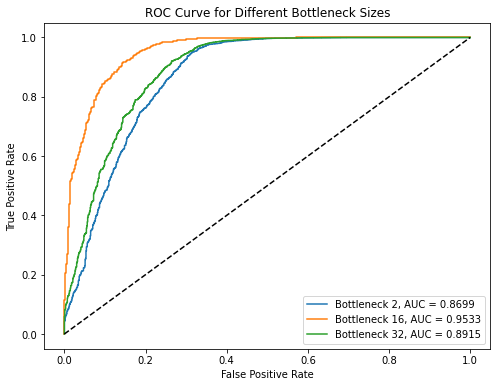

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Function to train the autoencoder with different bottleneck sizes
def train_autoencoder(bottleneck_size, num_epochs=10):
    model = AutoEncoder(bottleneck_size=bottleneck_size)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_criterion = nn.MSELoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            reconstructed = model(data)
            loss = loss_criterion(reconstructed, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Bottleneck size {bottleneck_size}, Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')

    return model

# Function to compute the ROC AUC score
def compute_auc_roc(model, threshold=0.02):
    true_labels = []
    reconstruction_errors = []

    model.eval()
    for batch_idx, (data, labels) in enumerate(test_loader):
        with torch.no_grad():
            reconstructed = model(data)
            for i in range(len(data)):
                loss = loss_criterion(reconstructed[i], data[i]).item()
                reconstruction_errors.append(loss)
                # True label
                if labels[i].item() == normal_dig:
                    true_labels.append(0)  # Normal
                else:
                    true_labels.append(1)  # Anomalous

    # Compute ROC-AUC score
    auc_score = roc_auc_score(true_labels, reconstruction_errors)
    fpr, tpr, _ = roc_curve(true_labels, reconstruction_errors)
    
    return auc_score, fpr, tpr

# Choose three different bottleneck dimensions
bottleneck_sizes = [2, 16, 32]
auc_scores = []
roc_curves = []

for bottleneck_size in bottleneck_sizes:
    # Train model with the current bottleneck size
    model = train_autoencoder(bottleneck_size=bottleneck_size, num_epochs=5)
    
    # Compute AUC-ROC score
    auc_score, fpr, tpr = compute_auc_roc(model)
    auc_scores.append(auc_score)
    roc_curves.append((fpr, tpr))
    
    print(f'Bottleneck Size: {bottleneck_size}, AUC-ROC Score: {auc_score}')

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i, (fpr, tpr) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f'Bottleneck {bottleneck_sizes[i]}, AUC = {auc_scores[i]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Bottleneck Sizes')
plt.legend(loc='lower right')
plt.show()


##### Bottleneck 2
The relatively lower AUC indicates that the severe compression (only 2 latent features) may be causing underfitting: the model is not able to learn and represent enough information from the input data.

#### Bottleneck 16
The highest AUC among the three suggests that this intermediate bottleneck dimension provides the best trade-off between representational capacity and generalization.

#### Bottlenect 32
In this case, the AUC is higher than that of the very small bottleneck (2), but still below the performance of the bottleneck size 16. This implies that going bigger did not continue to improve performance and may even have led to a slight decrease, possibly from overfitting or less effective regularization.